## Model Robustness at The Prediction Stage: Model Calibration

Model calibration ensures that the model's predicted probabilities accurately reflect the true likelihood of the target event. Calibrated models yield more trustworthy and interpretable probabilities, aiding informed decision-making.
   
Here, we try to showcase how the calibration affects the prediction of a SVC classifier on the adapted Diabetes dataset. 

In [ ]:
!pip install scikit-learn --upgrade

### Importing Packages and Data Preparation

In this example, to better showcase the difference, we create an unbalanced dataset by using mean (instead of median) outputs as the threshold. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import StandardScaler


# Load the Diabetes dataset
diabetes_data = datasets.load_diabetes()
X = diabetes_data.data
y = diabetes_data.target
threshold = np.mean(y)
y_binary = (y > threshold).astype(int)

### Splitting data into training/Vlidation/Test Sets:
It is important to perform the calibration on the validation set to prevent data leakage and at the same time avoid overfitting on the training data.

In [2]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Standardiation and Model fitting:

In [3]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train uncalibrated SVC on the training set
svc = SVC(probability=True)
svc.fit(X_train, y_train)

SVC(probability=True)

### Model Calibration on the Validation set:

In [4]:
# Calibrate the SVC model on the validation set
svc_calibrated = CalibratedClassifierCV(estimator=svc, cv='prefit', method='isotonic')
svc_calibrated.fit(X_val, y_val)

CalibratedClassifierCV(cv='prefit', estimator=SVC(probability=True),
                       method='isotonic')

### Comparing the Claibration of Prediction before/after Model Calibration

We can use calibration curves and brier score to compare the calibration of the predictions before/after the model calibration.

Brier Score (Uncalibrated): 0.17804160709326294
Brier Score (Calibrated): 0.1584720923356902


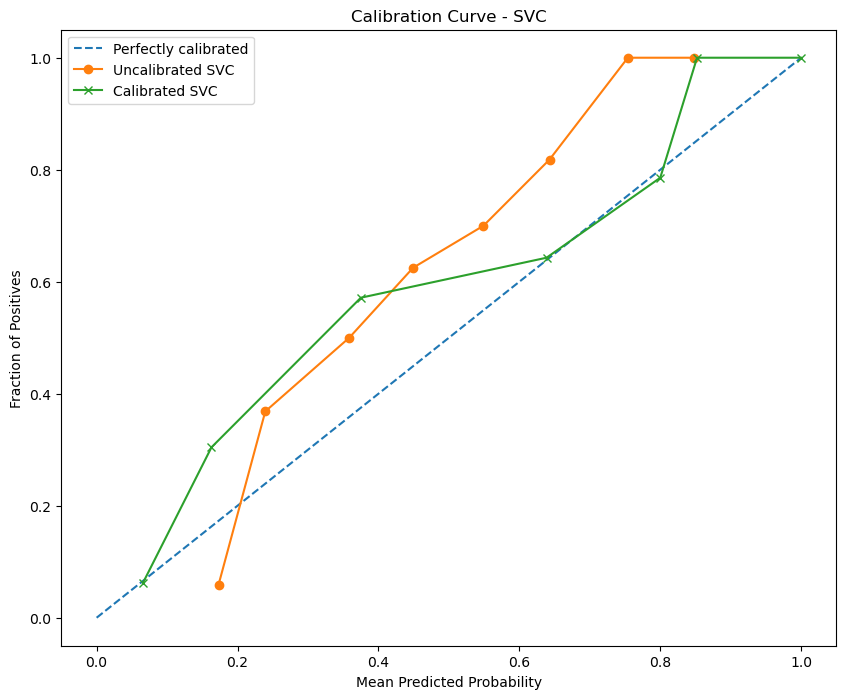

In [5]:

# Predict probabilities on the test set
probs_svc = svc.predict_proba(X_test)[:, 1]
probs_svc_calibrated = svc_calibrated.predict_proba(X_test)[:, 1]

# Compute calibration curve for SVC
fraction_of_positives_svc, mean_predicted_value_svc = calibration_curve(y_test, probs_svc, n_bins=10)

# Compute calibration curve for calibrated SVC
fraction_of_positives_svc_calibrated, mean_predicted_value_svc_calibrated = calibration_curve(y_test, probs_svc_calibrated, n_bins=10)

# Compute Brier scores
brier_uncalibrated = brier_score_loss(y_test, probs_svc)
brier_calibrated = brier_score_loss(y_test, probs_svc_calibrated)

print("Brier Score (Uncalibrated):", brier_uncalibrated)
print("Brier Score (Calibrated):", brier_calibrated)

# Plot the calibration curve
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.plot(mean_predicted_value_svc, fraction_of_positives_svc, marker='o', label='Uncalibrated SVC')
plt.plot(mean_predicted_value_svc_calibrated, fraction_of_positives_svc_calibrated, marker='x', label='Calibrated SVC')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - SVC')
plt.legend()
plt.show()
